In [137]:
# --- IMPORTS ---
import os
import glob
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import rasterio
import subprocess
from rasterstats import zonal_stats
from sodapy import Socrata
from shapely.geometry import shape
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings

# --- CONFIGURATION ---
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")

In [138]:
#getting the noise data
data_dir = "data/CONUS_rail_road_and_aviation_noise_2020/State_rasters/"
search_pattern = os.path.join(data_dir, "*_rail_road_and_aviation_noise_2020.tif")
output_vrt = os.path.join(data_dir, "CONUS_merged_noise_map_2020.vrt")

tif_files = glob.glob(search_pattern)

if not tif_files:
    print(f"--- ERROR ---")
    print(f"No .tif files were found at: {search_pattern}")
else:
    print(f"Found {len(tif_files)} state raster files to link.")
    
    command_list = ["gdalbuildvrt", output_vrt] + tif_files
    
    print("Building VRT file...")
    
    try:
        subprocess.run(command_list, check=True, shell=True)
        
        print(f"\n--- Success! ---")
        print(f"Virtual Raster .vrt file created at:")
        print(output_vrt)
        
    except subprocess.CalledProcessError as e:
        print(f"\n--- GDAL ERROR ---")
        print(f"The command failed: {e}")
        print("Please ensure GDAL is installed in your active Conda environment.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

Found 49 state raster files to link.
Building VRT file...

--- Success! ---
Virtual Raster .vrt file created at:
data/CONUS_rail_road_and_aviation_noise_2020/State_rasters/CONUS_merged_noise_map_2020.vrt


In [139]:
data_dir = "data/CONUS_rail_road_and_aviation_noise_2020/State_rasters/"
NOISE_RASTER_PATH = os.path.join(data_dir, "CONUS_merged_noise_map_2020.vrt")
CDC_APP_TOKEN = "ReEZWmd3hqYSQ879UCZyhtP1T" 

In [140]:
# --- HELPER CLASS ---
class DataPipeline:
    """
    Handles data ingestion and geometry processing for CDC and Census data.
    """
    def __init__(self, cdc_token, noise_path):
        self.cdc_token = cdc_token
        self.noise_path = noise_path
        self.NE_STATES = ['PA', 'NJ', 'NY', 'CT', 'RI', 'MA', 'NH', 'VT', 'ME']

    def get_cdc_data(self, limit=50000):
        """Fetches and cleans CDC PLACES data."""
        print(f"Fetching {limit} records from CDC API...")
        client = Socrata("data.cdc.gov", self.cdc_token)
        dataset_id = "swc5-untb"
        results = client.get(dataset_id, limit=limit)
        
        gdf = gpd.GeoDataFrame.from_records(results)
        
        # Geometry processing
        gdf = gdf.dropna(subset=['geolocation'])
        gdf['geometry'] = gdf['geolocation'].apply(lambda x: shape(x))
        gdf = gdf.set_geometry('geometry', crs="EPSG:4326")
        
        # Filter for NE States
        gdf = gdf[gdf['stateabbr'].isin(self.NE_STATES)]
        
        # Numeric conversion
        gdf['data_value'] = pd.to_numeric(gdf['data_value'], errors='coerce')
        return gdf

    def get_counties(self):
        """Fetches US County boundaries."""
        print("Downloading County Boundaries...")
        url = "https://www2.census.gov/geo/tiger/TIGER2022/COUNTY/tl_2022_us_county.zip"
        counties = gpd.read_file(url)
        counties = counties.to_crs("EPSG:4326")
        
        # Create FIPS
        counties['FIPS'] = counties['STATEFP'] + counties['COUNTYFP']
        return counties[['FIPS', 'geometry']]

# --- UTILITY FUNCTIONS ---
def calculate_vif(df):
    """Calculates Variance Inflation Factor to check for multicollinearity."""
    # Handle infinite/nan values just in case
    df = df.replace([np.inf, -np.inf], np.nan).dropna()
    vif_data = pd.DataFrame()
    vif_data["feature"] = df.columns
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(len(df.columns))]
    return vif_data.sort_values('VIF', ascending=False)

def plot_correlation_matrix(df, title="Correlation Matrix"):
    """Plots a publication-quality heatmap."""
    plt.figure(figsize=(10, 8))
    corr = df.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    sns.heatmap(corr, mask=mask, cmap='RdBu_r', center=0, square=True, linewidths=.5)
    plt.title(title, fontsize=14)
    plt.tight_layout()
    plt.show()

# Initialize Pipeline
pipeline = DataPipeline(CDC_APP_TOKEN, NOISE_RASTER_PATH)

In [141]:
# 1. Load Data
cdc_gdf = pipeline.get_cdc_data(limit=250000)
counties_gdf = pipeline.get_counties()

# 2. Pivot CDC Data (Wide Format)
# We need rows = Counties, Columns = Health Outcomes + SES
print("Pivoting CDC data...")
health_pivot = cdc_gdf.pivot_table(
    index=['locationid', 'locationname', 'stateabbr'],
    columns='measure',
    values='data_value',
    aggfunc='mean'
).reset_index()

Fetching 250000 records from CDC API...
Pivoting CDC data...


In [142]:
# 3. Merge with Geometries
model_gdf = counties_gdf.merge(health_pivot, left_on='FIPS', right_on='locationid', how='inner')

In [ ]:
model_gdf = model_gdf.set_geometry('geometry')

print(f"Final Dataset: {len(model_gdf)} counties ready for analysis.")

Final Dataset: 218 counties ready for analysis.


In [186]:
PA = counties_gdf[counties_gdf['FIPS'].str.startswith('42')]

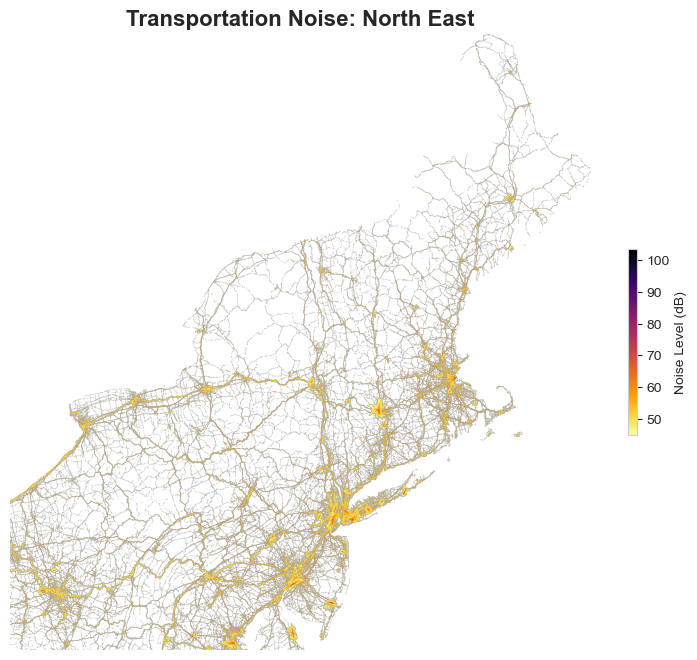

In [203]:
import rasterio
from rasterio.mask import mask
from rasterio.plot import show
from rasterio.windows import from_bounds
from rasterio.enums import Resampling
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import mapping
import numpy as np

DOWNSAMPLE_FACTOR = 0.1

with rasterio.open(NOISE_RASTER_PATH) as src:
        model_gdf = model_gdf.to_crs(src.crs)
        minx, miny, maxx, maxy = model_gdf.total_bounds
        window = from_bounds(minx, miny, maxx, maxy, src.transform)
        new_height = int(window.height * DOWNSAMPLE_FACTOR)
        new_width = int(window.width * DOWNSAMPLE_FACTOR)
        out_image = src.read(
        1,
        window=window,
        out_shape=(new_height, new_width),
        resampling=Resampling.bilinear
    )

noise_data_masked = np.ma.masked_less_equal(out_image, 0)

fig, ax = plt.subplots(figsize=(12, 8))

img = ax.imshow(
    noise_data_masked, 
    cmap='inferno_r', 
    extent=(minx, maxx, miny, maxy),
    origin='upper'
)

# Formatting
plt.colorbar(img, ax=ax, label="Noise Level (dB)", fraction=0.01, pad=0.04)
plt.title("Transportation Noise: North East", fontsize=16, fontweight='bold')
plt.xlabel("Longitude")
plt.ylabel("Latitude")

ax.set_axis_off()

plt.tight_layout
plt.show()

First attempted regression

In [144]:
# 1. Calculate Naive Zonal Statistics (Arithmetic Mean)
# Note: This is physically incorrect for decibels, but demonstrated for baseline comparison.
with rasterio.open(NOISE_RASTER_PATH) as src:
    target_crs = src.crs
    nodata_val = src.nodata

model_gdf = model_gdf.to_crs(target_crs)

stats_arithmetic = zonal_stats(
    model_gdf,
    NOISE_RASTER_PATH,
    stats=['mean'],
    all_touched=True,
    band=1,
    nodata=nodata_val
)

result_gdf = pd.DataFrame(stats_arithmetic)
result_gdf['locationid'] = model_gdf['locationid'].values
result_gdf = result_gdf.rename(columns={'mean': 'avg_noise_db'})
result_gdf = result_gdf.dropna(subset=['avg_noise_db'])

In [145]:
model_gdf = model_gdf.merge(
    result_gdf,
    on='locationid',
    how='left'
)

In [146]:
# TARGET (y) = Noise 
# FEATURES (X) = All Health Outcomes
target = 'avg_noise_db'
features = [col for col in model_gdf.columns if col not in ['FIPS', 'geometry', 'locationid', 'locationname', 'stateabbr', 'naive_noise_db']]

X = model_gdf[features].dropna()
y = model_gdf.loc[X.index, target]

In [147]:
# Run Random Forest
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
rf_naive = RandomForestRegressor(random_state=42)
rf_naive.fit(X_train, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False



 Model R² Score: 0.9620
                                              feature          VIF
9                 Coronary heart disease among adults  8052.084383
38  Visited dentist or dental clinic in the past y...  7944.017177
32                  Self-care disability among adults  7598.641118
35  Taking medicine to control high blood pressure...  7556.890581
19            Frequent physical distress among adults  7468.313397
39  Visits to doctor for routine checkup within th...  6741.279607
37                     Vision disability among adults  6636.673746
34                                Stroke among adults  6292.508869
15  Fair or poor self-rated health status among ad...  6247.298957
18              Frequent mental distress among adults  5350.840512


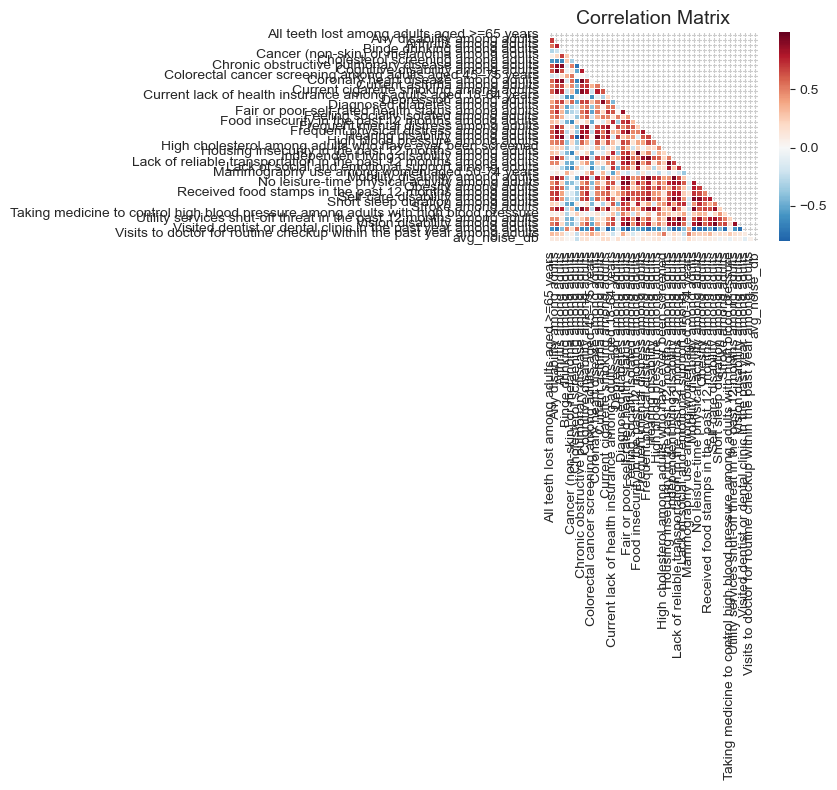

In [148]:
# Diagnostic Outputs
print(f"\n Model R² Score: {rf_naive.score(X_test, y_test):.4f}")

vif_df = calculate_vif(X)
print(vif_df.head(10))

# Plot Correlation
plot_correlation_matrix(X)

In [172]:
# 1. DEFINE CENSUS FETCHING FUNCTION
# ---------------------------------------------------------
def fetch_census_data_standalone():
    """
    Fetches 2023 ACS 5-Year Data via US Census API for Northeast States.
    Returns a cleaned DataFrame ready for merging.
    """
    print("Fetching US Census ACS Data (Income, Poverty, Race, Education)...")
    
    # NE State FIPS: CT, ME, MA, NH, NJ, NY, PA, RI, VT
    ne_fips = ["09", "23", "25", "33", "34", "36", "42", "44", "50"]
    
    # Map API variables to readable names
    vars_map = {
        "B01003_001E": "Total_Pop",
        "B19013_001E": "Median_Income",
        "B17001_002E": "Poverty_Count",
        "B03002_003E": "White_Count",
        "B03002_004E": "Black_Count",
        "B15003_022E": "Bachelor_Degree_Count"
    }
    
    var_string = ",".join(vars_map.keys())
    dfs = []
    
  
    for fips in ne_fips:
        url = f"https://api.census.gov/data/2023/acs/acs5?get=NAME,{var_string}&for=county:*&in=state:{fips}"
        try:
            df = pd.read_json(url)
            df.columns = df.iloc[0]
            df = df[1:]
            dfs.append(df)
        except Exception as e:
                print(f"   ! Error fetching state {fips}: {e}")
        
    if not dfs:
         raise ValueError("Failed to fetch Census data.")
    
    census = pd.concat(dfs, ignore_index=True)
    
    # Create 5-digit FIPS for merging (State + County)
    census['FIPS'] = census['state'] + census['county']
    
    # Rename columns
    census = census.rename(columns=vars_map)
    
    # Convert to Numeric
    for col in vars_map.values():
        census[col] = pd.to_numeric(census[col], errors='coerce')
        
    census['Pct_Poverty'] = (census['Poverty_Count'] / census['Total_Pop']) * 100
    census['Pct_White'] = (census['White_Count'] / census['Total_Pop']) * 100
    census['Pct_Black'] = (census['Black_Count'] / census['Total_Pop']) * 100
    census['Pct_Degree'] = (census['Bachelor_Degree_Count'] / census['Total_Pop']) * 100
    census['Log_Income'] = np.log1p(census['Median_Income'])
    
    # Select final columns
    return census[['FIPS', 'Total_Pop', 'Log_Income', 'Pct_Poverty', 'Pct_White', 'Pct_Black', 'Pct_Degree']]

In [176]:
census_df = fetch_census_data_standalone()

Fetching US Census ACS Data (Income, Poverty, Race, Education)...


In [177]:
# Ensure key types match (strings)
model_gdf['FIPS'] = model_gdf['locationid'].astype(str).str.zfill(5)
census_df['FIPS'] = census_df['FIPS'].astype(str).str.zfill(5)

# Perform Merge
final_df = model_gdf.merge(census_df, left_on='FIPS', right_on='FIPS', how='left')

# Physics Correction: Log-Transform the Noise (Decibels are logarithmic, but health impacts often scale linearly with Log(Energy))
# Note: We use the 'avg_noise_db' you calculated in your previous cells
final_df['Log_Noise_Exposure'] = np.log1p(final_df['avg_noise_db'])

print(f"Final Dataset with Census Data: {len(final_df)} counties.")

Final Dataset with Census Data: 218 counties.


CT decided to change their county shape in addition to the total number of county's they have from 8 to 9. This change happened on August 2024, which means there is no way to get ACS 5 data from CT as the earliest ACS 5 data we can get is in 2023. 

The two options I have is either to use the less reliable ACS 1 year data's, or I 

In [178]:
# 3. RUN CORRECTED REGRESSION LOOP
# ---------------------------------------------------------
print("\n--- RUNNING ROBUST RIDGE REGRESSIONS ---")

# Define inputs (X) - Socioeconomics + Noise
features = ['Log_Noise_Exposure', 'Log_Income', 'Pct_Poverty', 'Pct_Black', 'Pct_Degree']

# Define Health Outcomes (y)
outcomes_of_interest = [
    'Depression among adults',
    'High blood pressure among adults', 
    'Stroke among adults',
    'Sleep duration < 7 hours among adults aged >=18 years', 
    'Arthritis among adults', 
    'Cancer (non-skin) or melanoma among adults', 
    'Chronic obstructive pulmonary disease among adults', 
    'Cognitive disability among adults', 
    'Coronary heart disease among adults', 
    'Current asthma among adults', 
    'Diagnosed diabetes among adults', 
    'Fair or poor self-rated health status among adults', 
    'Frequent mental distress among adults',
    'Hearing disability among adults',
    'High cholesterol among adults who have ever been screened', 
    'Mobility disability among adults', 
    'Obesity among adults', 
    'Vision disability among adults'
]

results_list = []

for outcome in outcomes_of_interest:
    # Skip if outcome not in data
    if outcome not in final_df.columns:
        continue
        
    # Drop NaNs for this specific combination
    df_mod = final_df.dropna(subset=features + [outcome])
    
    if len(df_mod) < 10:
        print(f"Skipping {outcome}: Not enough data.")
        continue

    X = df_mod[features]
    y = df_mod[outcome]
    
    # Split Data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Scale Data (Important for comparing coefficients of Noise vs Income)
    scaler = StandardScaler()
    X_train_sc = scaler.fit_transform(X_train)
    X_test_sc = scaler.transform(X_test)
    
    # Ridge Regression (Handles multicollinearity between Income/Poverty better than LinearRegression)
    model = Ridge(alpha=1.0)
    model.fit(X_train_sc, y_train)
    
    # Calculate R2
    r2 = r2_score(y_test, model.predict(X_test_sc))
    
    # Extract Noise Coefficient (Index 0 is 'Log_Noise_Exposure')
    noise_coef = model.coef_[0]
    
    results_list.append({
        'Health Outcome': outcome.split(" among")[0],
        'R2 Score': r2,
        'Noise Impact (Beta)': noise_coef
    })
    
    print(f"Outcome: {outcome[:15]}... | R²: {r2:.3f} | Noise Beta: {noise_coef:.3f}")


--- RUNNING ROBUST RIDGE REGRESSIONS ---
Outcome: Depression amon... | R²: 0.605 | Noise Beta: 0.037
Outcome: High blood pres... | R²: 0.607 | Noise Beta: -0.120
Outcome: Stroke among ad... | R²: 0.731 | Noise Beta: -0.002
Outcome: Arthritis among... | R²: 0.639 | Noise Beta: -0.101
Outcome: Cancer (non-ski... | R²: 0.714 | Noise Beta: -0.007
Outcome: Chronic obstruc... | R²: 0.738 | Noise Beta: 0.017
Outcome: Cognitive disab... | R²: 0.603 | Noise Beta: -0.009
Outcome: Coronary heart ... | R²: 0.649 | Noise Beta: -0.017
Outcome: Current asthma ... | R²: 0.333 | Noise Beta: 0.031
Outcome: Diagnosed diabe... | R²: 0.578 | Noise Beta: -0.028
Outcome: Fair or poor se... | R²: 0.638 | Noise Beta: -0.035
Outcome: Frequent mental... | R²: 0.697 | Noise Beta: -0.015
Outcome: Hearing disabil... | R²: 0.737 | Noise Beta: -0.001
Outcome: High cholestero... | R²: -0.023 | Noise Beta: -0.128
Outcome: Mobility disabi... | R²: 0.691 | Noise Beta: 0.013
Outcome: Obesity among a... | R²: 0.595 | Nois

In [179]:
vif_features = ['Log_Noise_Exposure', 'Log_Income', 'Pct_Poverty', 'Pct_Black', 'Pct_Degree']
X_vif = final_df[vif_features].dropna()
X_vif['const'] = 1
vif_data = pd.DataFrame()
vif_data["Feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) 
                   for i in range(len(X_vif.columns))]
vif_display = vif_data[vif_data["Feature"] != 'const'].sort_values('VIF', ascending=False)
print(vif_display)

              Feature       VIF
1          Log_Income  4.571799
2         Pct_Poverty  3.019654
4          Pct_Degree  2.863944
3           Pct_Black  1.609137
0  Log_Noise_Exposure  1.058018


All features have a VIF below 5, showing low correlation between features

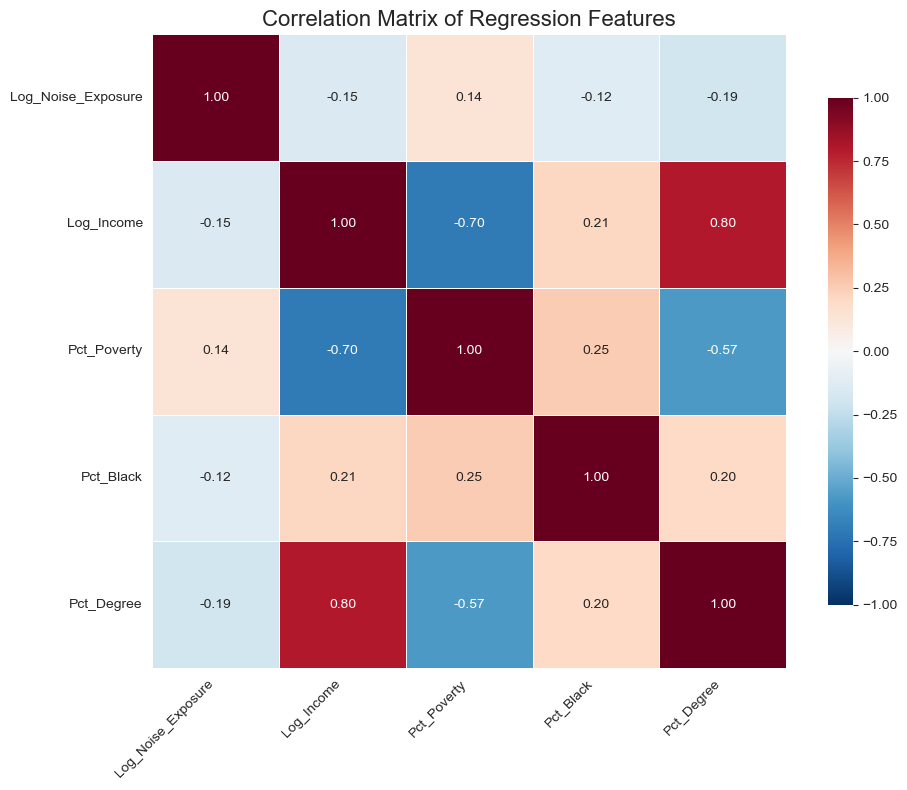

In [180]:
corr_matrix = final_df[vif_features].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix, 
    annot=True,       # Show the numbers in the boxes
    fmt=".2f",        # Round to 2 decimal places
    cmap='RdBu_r',    # Red/Blue diverging colormap (Red=Pos, Blue=Neg)
    center=0,         # Center the colormap at 0
    vmin=-1, vmax=1,  # Fix scale from -1 to 1
    square=True,      # Force square aspect ratio
    linewidths=.5,    # Add lines between squares
    cbar_kws={"shrink": .8}
)
plt.title('Correlation Matrix of Regression Features', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

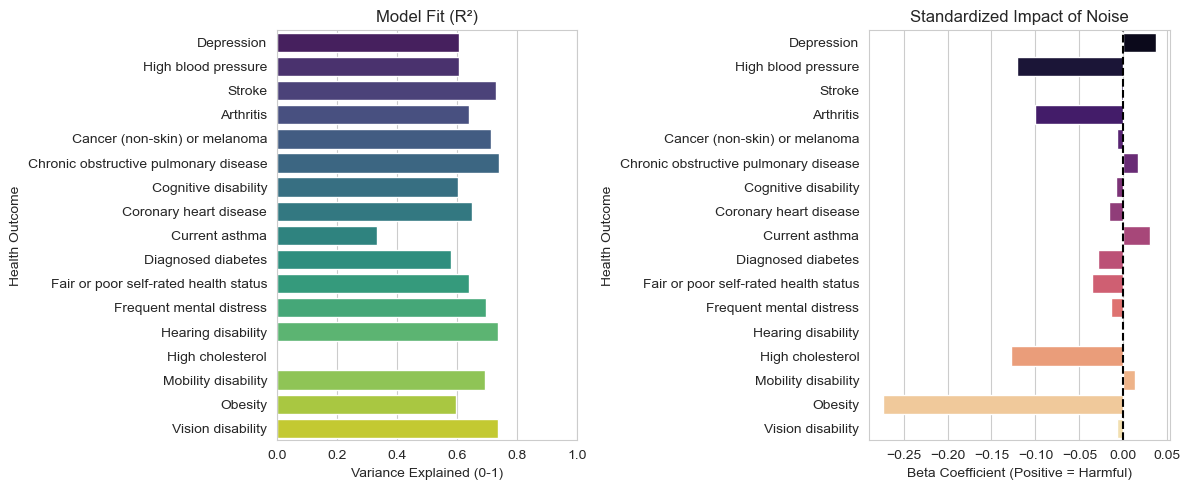

In [181]:
# 4. VISUALIZE RESULTS
# ---------------------------------------------------------
if results_list:
    res_df = pd.DataFrame(results_list)

    plt.figure(figsize=(12, 5))

    # Plot 1: R2 Scores
    plt.subplot(1, 2, 1)
    sns.barplot(data=res_df, x='R2 Score', y='Health Outcome', palette='viridis')
    plt.title("Model Fit (R²)")
    plt.xlabel("Variance Explained (0-1)")
    plt.xlim(0, 1)

    # Plot 2: Noise Coefficients
    plt.subplot(1, 2, 2)
    sns.barplot(data=res_df, x='Noise Impact (Beta)', y='Health Outcome', palette='magma')
    plt.title("Standardized Impact of Noise")
    plt.xlabel("Beta Coefficient (Positive = Harmful)")
    plt.axvline(0, color='black', linestyle='--')

    plt.tight_layout()
    plt.show()
else:
    print("No matching health outcomes found to plot.")

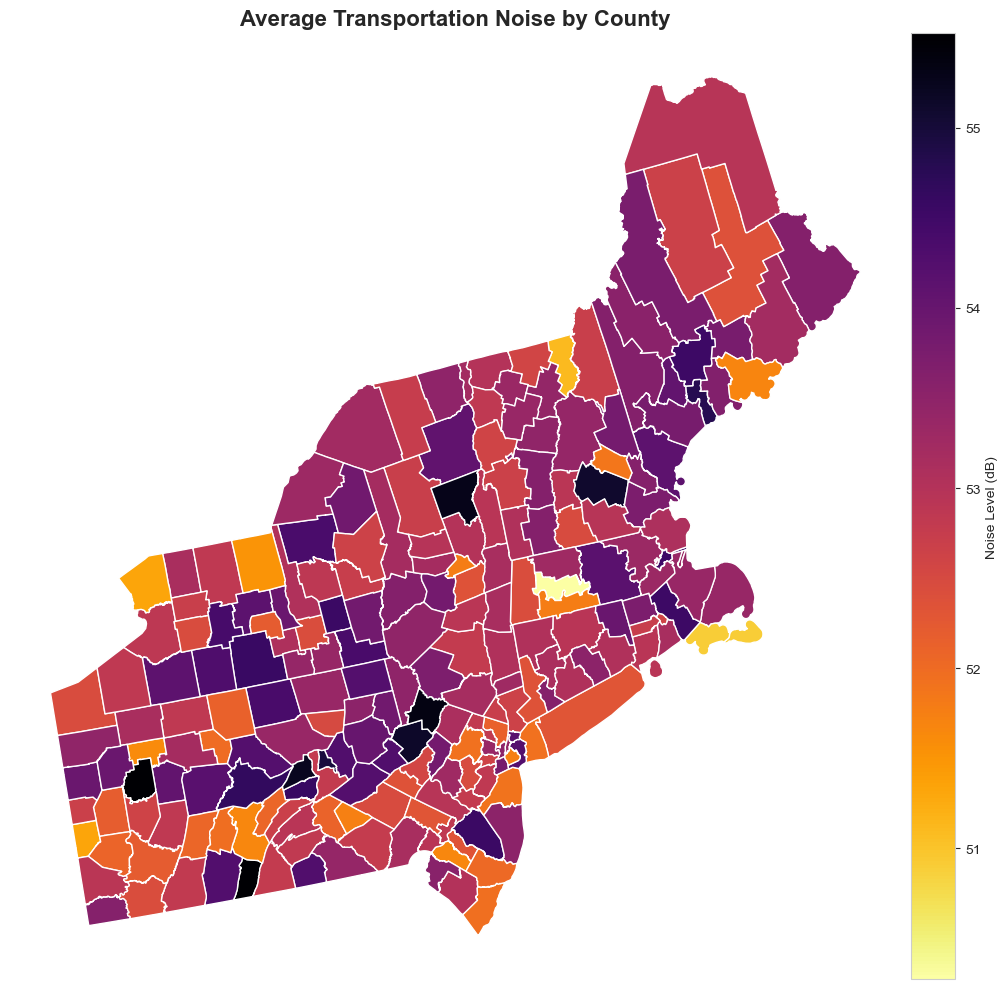

In [183]:
# ==========================================
# PHASE 3: SPATIAL VISUALIZATION
# ==========================================
import matplotlib.pyplot as plt
import geopandas as gpd
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_noise_map(gdf, noise_col='avg_noise_db', title='Average Transportation Noise by County'):
    """
    Plots a choropleth map of noise levels.
    """
    # 1. Prepare Data (Ensure it's a GeoDataFrame)
    if not isinstance(gdf, gpd.GeoDataFrame):
        print("Converting to GeoDataFrame...")
        gdf = gpd.GeoDataFrame(gdf, geometry='geometry')
    
    # Check if column exists
    if noise_col not in gdf.columns:
        # Fallback to other likely names from previous steps
        options = ['Noise_Mean_dB', 'noise_db', 'Log_Noise_Exposure']
        for opt in options:
            if opt in gdf.columns:
                noise_col = opt
                print(f"Using '{noise_col}' for plotting.")
                break
        else:
            print(f"Error: Could not find noise column '{noise_col}' in dataset.")
            return

    # 2. Setup Plot
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)

    # 3. Plot
    gdf.plot(
        column=noise_col,
        ax=ax,
        legend=True,
        cax=cax,
        cmap='inferno_r', 
        legend_kwds={'label': "Noise Level (dB)"},
        missing_kwds={'color': 'lightgrey', 'label': 'Missing Data'}
    )

    # 4. Formatting
    ax.set_title(title, fontsize=16, fontweight='bold')
    ax.set_axis_off() 
    
    plt.tight_layout()
    plt.show()

# --- EXECUTE PLOT ---
# Try to plot using the 'final_df' from Phase 2, or fallback to 'model_gdf'
plot_noise_map(final_df, noise_col='avg_noise_db')


K-means cluster analysis 

In [161]:
cluster_features = ['Log_Noise_Exposure', 'Log_Income', 'Pct_Poverty', 'Pct_Black', 'Pct_Degree']
X_cluster = final_df[cluster_features].dropna()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

X_cluster['Cluster'] = clusters
X_cluster['Cluster_Name'] = X_cluster['Cluster'].map({
    0: 'Group A', 1: 'Group B', 2: 'Group C'
})

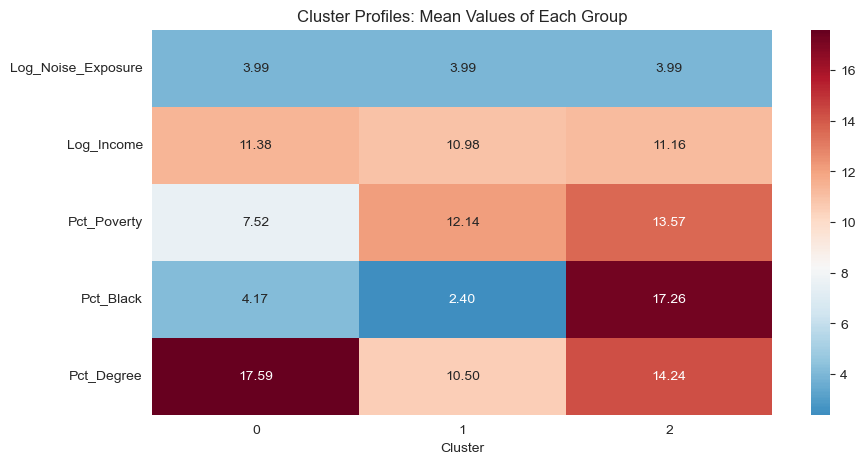

In [162]:
cluster_means = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=cluster_features)
cluster_means['Cluster'] = [0, 1, 2]
plt.figure(figsize=(10, 5))
sns.heatmap(
    cluster_means.set_index('Cluster').T, 
    annot=True, 
    cmap='RdBu_r', 
    fmt='.2f',
    center=cluster_means.mean().mean()
)
plt.title("Cluster Profiles: Mean Values of Each Group")
plt.show()

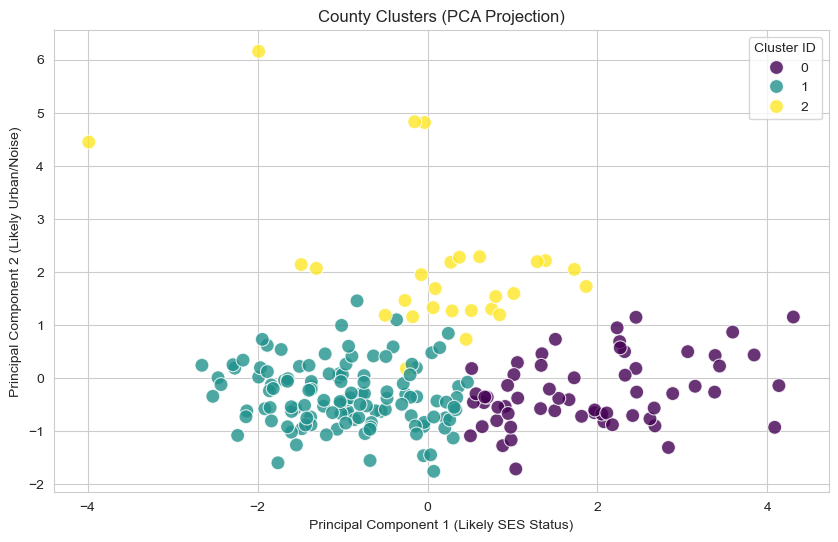

In [163]:
pca = PCA(n_components=2)
coords = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=coords[:,0], y=coords[:,1], hue=X_cluster['Cluster'], palette='viridis', s=100, alpha=0.8)
plt.title("County Clusters (PCA Projection)")
plt.xlabel("Principal Component 1 (Likely SES Status)")
plt.ylabel("Principal Component 2 (Likely Urban/Noise)")
plt.legend(title='Cluster ID')
plt.show()

INTERACTION EFFECTS, Does Poverty amplify the harm of Noise?

In [ ]:
target_health = 'Depression among adults' # Example outcome

df_int = final_df[[target_health, 'Log_Noise_Exposure', 'Pct_Poverty']].dropna()
    
    # Create "Interaction Term"
    # Interaction = Noise * Poverty
df_int['Interaction_Term'] = df_int['Log_Noise_Exposure'] * df_int['Pct_Poverty']
    
    # 2. Run Regression
X_int = df_int[['Log_Noise_Exposure', 'Pct_Poverty', 'Interaction_Term']]
y_int = df_int[target_health]
    
lm = LinearRegression()
lm.fit(X_int, y_int)
    
    # 3. Visualization: Interaction Plot
    # We split data into "High Poverty" vs "Low Poverty" counties to visualize the difference slopes
    
    # Define median poverty split
pov_median = df_int['Pct_Poverty'].median()
df_int['Poverty_Level'] = np.where(df_int['Pct_Poverty'] > pov_median, 'High Poverty', 'Low Poverty')
    
plt.figure(figsize=(10, 6))
sns.lmplot(
    data=df_int, 
    x='Log_Noise_Exposure', 
    y=target_health, 
    hue='Poverty_Level',
    palette={'High Poverty': 'red', 'Low Poverty': 'blue'},
    height=6, aspect=1.5,
    scatter_kws={'alpha': 0.3}
)
plt.title(f"Interaction Effect: Noise vs {target_health}\nby Poverty Level")
plt.xlabel("Log Noise Exposure")
plt.ylabel(f"Prevalence: {target_health}")
plt.show()

TypeError: unhashable type: 'list'


--- PHASE 3: MULTIPLE LOGISTIC REGRESSION ---
(Predicting: Is a county 'High Risk' or 'Low Risk' for this outcome?)

Outcome: Depression
   > Cutoff (Median %): 23.7%
   > Accuracy: 88.89%
   > Noise Odds Ratio: 1.097
     (OR > 1.00 means higher noise increases risk)

Outcome: High blood pressure
   > Cutoff (Median %): 31.3%
   > Accuracy: 82.54%
   > Noise Odds Ratio: 0.728
     (OR > 1.00 means higher noise increases risk)

Outcome: Stroke
   > Cutoff (Median %): 3.3%
   > Accuracy: 76.19%
   > Noise Odds Ratio: 1.191
     (OR > 1.00 means higher noise increases risk)

Outcome: Arthritis
   > Cutoff (Median %): 27.7%
   > Accuracy: 73.02%
   > Noise Odds Ratio: 0.892
     (OR > 1.00 means higher noise increases risk)

Outcome: Cancer (non-skin) or melanoma
   > Cutoff (Median %): 8.4%
   > Accuracy: 80.95%
   > Noise Odds Ratio: 1.045
     (OR > 1.00 means higher noise increases risk)

Outcome: Chronic obstructive pulmonary disease
   > Cutoff (Median %): 7.2%
   > Accuracy: 84.13

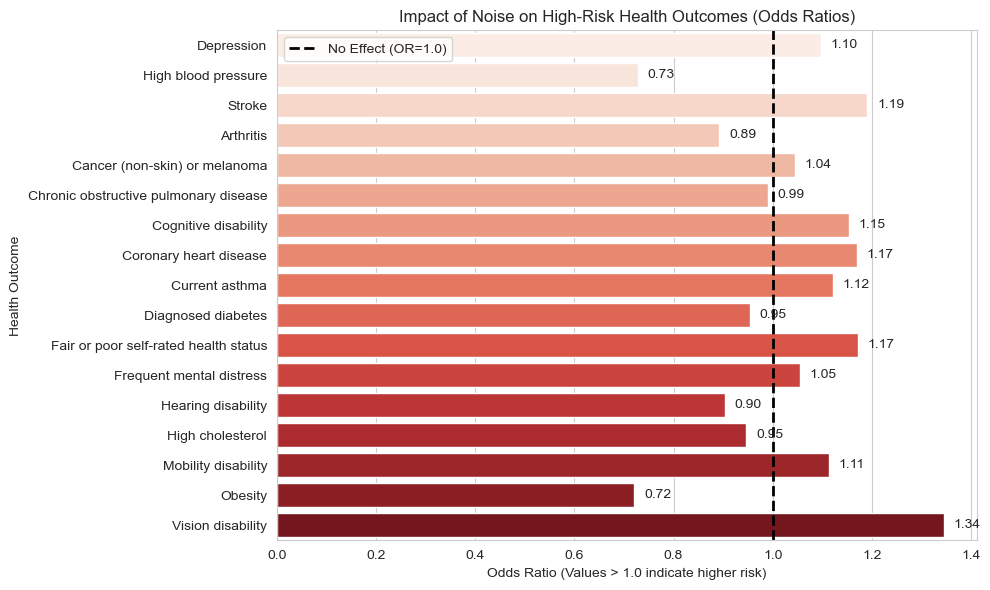

In [174]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

print("\n--- PHASE 3: MULTIPLE LOGISTIC REGRESSION ---")
print("(Predicting: Is a county 'High Risk' or 'Low Risk' for this outcome?)")

# 1. Define Features & Outcomes
features = ['Log_Noise_Exposure', 'Log_Income', 'Pct_Poverty', 'Pct_Black', 'Pct_Degree']


results_logistic = []

for outcome in outcomes_of_interest:
    if outcome not in final_df.columns:
        continue
        
    # 2. Prepare Data
    df_mod = final_df.dropna(subset=features + [outcome]).copy()
    
    # --- CRITICAL STEP: BINARIZATION ---
    # Convert continuous % to Binary (0 or 1) based on the Median
    median_val = df_mod[outcome].median()
    df_mod['Target_Binary'] = (df_mod[outcome] > median_val).astype(int)
    
    X = df_mod[features]
    y = df_mod['Target_Binary']
    
    # 3. Split Data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Scale Features (Required for Logistic Regression regularization)
    scaler = StandardScaler()
    X_train_sc = scaler.fit_transform(X_train)
    X_test_sc = scaler.transform(X_test)
    
    # 4. Train Logistic Regression
    # C=1.0 is standard regularization. solver='liblinear' is good for smaller datasets.
    log_reg = LogisticRegression(C=1.0, solver='liblinear', random_state=42)
    log_reg.fit(X_train_sc, y_train)
    
    # 5. Evaluate
    y_pred = log_reg.predict(X_test_sc)
    acc = accuracy_score(y_test, y_pred)
    
    # 6. Extract Odds Ratios
    # Coefs are log-odds; exponentiate them to get Odds Ratios
    # Index 0 corresponds to 'Log_Noise_Exposure'
    noise_log_odds = log_reg.coef_[0][0] 
    noise_odds_ratio = np.exp(noise_log_odds)
    
    results_logistic.append({
        'Health Outcome': outcome.split(" among")[0],
        'Accuracy': acc,
        'Noise Odds Ratio': noise_odds_ratio,
        'Median_Cutoff': median_val
    })
    
    print(f"\nOutcome: {outcome.split(' among')[0]}")
    print(f"   > Cutoff (Median %): {median_val:.1f}%")
    print(f"   > Accuracy: {acc:.2%}")
    print(f"   > Noise Odds Ratio: {noise_odds_ratio:.3f}")
    print(f"     (OR > 1.00 means higher noise increases risk)")

# ==========================================
# VISUALIZATION: ODDS RATIOS
# ==========================================
if results_logistic:
    res_df = pd.DataFrame(results_logistic)

    plt.figure(figsize=(10, 6))
    
    # Plot Odds Ratios
    sns.barplot(data=res_df, x='Noise Odds Ratio', y='Health Outcome', palette='Reds')
    
    # Add reference line at OR = 1 (No Effect)
    plt.axvline(1.0, color='black', linestyle='--', linewidth=2, label='No Effect (OR=1.0)')
    plt.legend()
    
    plt.title("Impact of Noise on High-Risk Health Outcomes (Odds Ratios)")
    plt.xlabel("Odds Ratio (Values > 1.0 indicate higher risk)")
    
    # Annotate values
    for index, row in res_df.iterrows():
        plt.text(row['Noise Odds Ratio'] + 0.02, index, f"{row['Noise Odds Ratio']:.2f}", va='center')

    plt.tight_layout()
    plt.show()